In [1]:
!git clone https://github.com/TencentARC/GFPGAN.git

Cloning into 'GFPGAN'...
remote: Enumerating objects: 426, done.
remote: Total 426 (delta 0), reused 0 (delta 0), pack-reused 426
Receiving objects: 100% (426/426), 5.36 MiB | 13.31 MiB/s, done.
Resolving deltas: 100% (214/214), done.


Then install the required libraries with `pip install -r GFPGAN/requirements.txt`  
You also need to download weights `GFPGANCleanv1-NoCE-C2.pth` and place to `experiments/pretrained_models/` folder

In [1]:
import cv2
import torch
import time
import os

from utils.inference.image_processing import crop_face, get_final_image, get_final_image_gfpgan, show_images
from utils.inference.video_processing import read_video, get_target, get_final_video, get_final_video_gfpgan, add_audio_from_another_video, face_enhancement_gfpgan
from utils.inference.core import model_inference

from network.AEI_Net import AEI_Net
from coordinate_reg.image_infer import Handler
from insightface_func.face_detect_crop_multi import Face_detect_crop
from arcface_model.iresnet import iresnet100
from models.pix2pix_model import Pix2PixModel
from models.config_sr import TestOptions

import warnings
warnings.filterwarnings('ignore')

/home/user/conda/envs/fs_sr/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/user/conda/envs/fs_sr/lib/python3.7/site-packages/kornia/augmentation/augmentation.py:1833: DeprecationWarning: GaussianBlur is no longer maintained and will be removed from the future versions. Please use RandomGaussianBlur instead.
  category=DeprecationWarning,
/home/user/conda/envs/fs_sr/lib/python3.7/site-packages/mxnet/numpy/utils.py:36: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bool = onp.bool


In [2]:
import sys

sys.path.append('./GFPGAN')
from gfpgan import GFPGANer

from facexlib.utils.face_restoration_helper import FaceRestoreHelper
from gfpgan.archs.gfpganv1_clean_arch import GFPGANv1Clean

### Load Models

In [3]:
app = Face_detect_crop(name='antelope', root='./insightface_func/models')
app.prepare(ctx_id= 0, det_thresh=0.6, det_size=(640,640))

# main model for generation
G = AEI_Net(backbone='unet', num_blocks=2, c_id=512)
G.eval()
G.load_state_dict(torch.load('weights/G_unet_2blocks.pth', map_location=torch.device('cpu')))
G = G.cuda()
G = G.half()

# arcface model to get face embedding
netArc = iresnet100(fp16=False)
netArc.load_state_dict(torch.load('arcface_model/backbone.pth'))
netArc=netArc.cuda()
netArc.eval()

# model to get face landmarks
handler = Handler('./coordinate_reg/model/2d106det', 0, ctx_id=0, det_size=640)

# model to make superres of face, set use_sr=True if you want to use super resolution or use_sr=False if you don't
use_sr = True
if use_sr:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    gfpgan = GFPGANv1Clean(
                    out_size=512,
                    num_style_feat=512,
                    channel_multiplier=2,
                    decoder_load_path=None,
                    fix_decoder=False,
                    num_mlp=8,
                    input_is_latent=True,
                    different_w=True,
                    narrow=1,
                    sft_half=True)

    loadnet = torch.load('GFPGAN/experiments/pretrained_models/GFPGANCleanv1-NoCE-C2.pth')
    gfpgan.load_state_dict(loadnet['params_ema'], strict=True)
    gfpgan.eval()
    gfpgan = gfpgan.to(device)

input mean and std: 127.5 127.5
find model: ./insightface_func/models/antelope/glintr100.onnx recognition
find model: ./insightface_func/models/antelope/scrfd_10g_bnkps.onnx detection
set det-size: (640, 640)
loading ./coordinate_reg/model/2d106det 0
input mean and std: 127.5 127.5
find model: ./insightface_func/models/antelope/glintr100.onnx recognition
find model: ./insightface_func/models/antelope/scrfd_10g_bnkps.onnx detection
set det-size: (640, 640)


[17:40:54] src/nnvm/legacy_json_util.cc:209: Loading symbol saved by previous version v1.5.0. Attempting to upgrade...
[17:40:54] src/nnvm/legacy_json_util.cc:217: Symbol successfully upgraded!


### Set here path to source image and video for faceswap

In [4]:
image_to_image = True

In [5]:
"""
choose not really long videos, coz it can take a lot of time othervise 
choose source image as a photo -- preferable a selfie of a person
"""
if image_to_image:
    path_to_target = 'examples/images/beckham.jpg'
else:
    path_to_video = 'examples/videos/nggyup.mp4'
source_full = cv2.imread('examples/images/elon_musk.jpg')
OUT_VIDEO_NAME = "examples/results/result.mp4"
crop_size = 224 # don't change this
BS = 60

In [6]:
# check, if we can detect face on the source image

try:    
    source = crop_face(source_full, app, crop_size)[0]
    source = [source[:, :, ::-1]]
    print("Everything is ok!")
except TypeError:
    print("Bad source images")

Everything is ok!


In [7]:
# read video and find target image in the video that contains at least 1 face

if image_to_image:
    target_full = cv2.imread(path_to_target)
    full_frames = [target_full]
else:
    full_frames, fps = read_video(path_to_video)
target = get_target(full_frames, app, crop_size)

### Model Inference

In [8]:
START_TIME = time.time()

In [9]:
final_frames_list, crop_frames_list, full_frames, tfm_array_list = model_inference(full_frames,
                                                                                   source,
                                                                                   target,
                                                                                   netArc,
                                                                                   G,
                                                                                   app,
                                                                                   set_target = False,
                                                                                   crop_size=crop_size,
                                                                                   BS=BS)

100%|██████████| 1/1 [00:00<00:00, 91.53it/s]
1it [00:00, 429.04it/s]
1it [00:00, 2364.32it/s]
100%|██████████| 1/1 [00:00<00:00, 20068.44it/s]


In [10]:
if use_sr:
    final_frames_list = face_enhancement_gfpgan(final_frames_list, gfpgan, device)

100%|██████████| 1/1 [00:00<00:00, 10.26it/s]


[17:40:56] src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


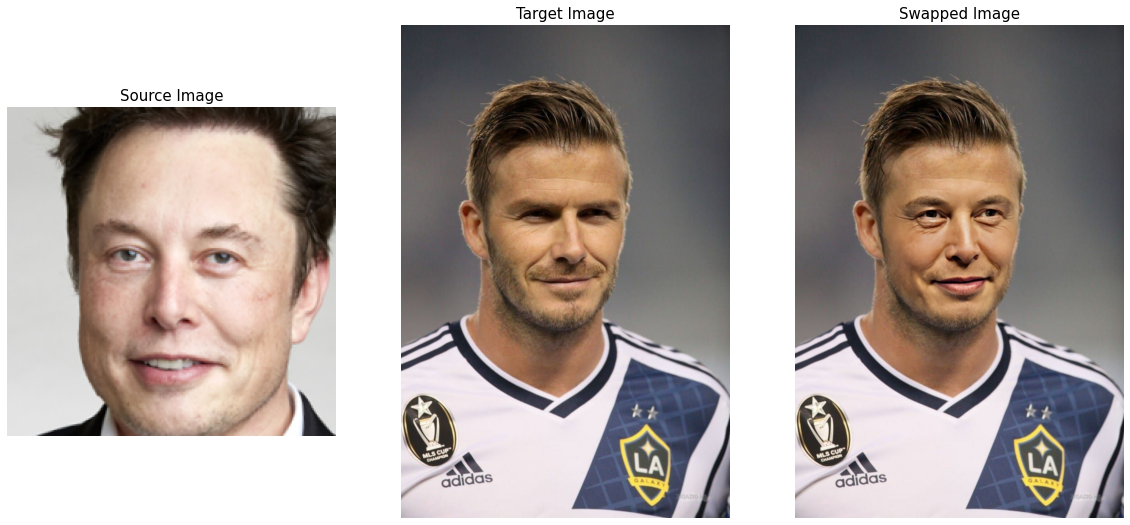

In [11]:
if image_to_image:
    if use_sr:
        result = get_final_image_gfpgan(final_frames_list, crop_frames_list, full_frames[0], tfm_array_list, handler)
    else:
        result = get_final_image(final_frames_list, crop_frames_list, full_frames[0], tfm_array_list, handler)
    show_images([source[0][:, :, ::-1], target_full, result], ['Source Image', 'Target Image', 'Swapped Image'], figsize=(20, 15))
else:
    if use_sr:
        get_final_video_gfpgan(final_frames_list,
                               crop_frames_list,
                               full_frames,
                               tfm_array_list,
                               OUT_VIDEO_NAME,
                               fps, 
                               handler)
    else:
        get_final_video(final_frames_list,
                    crop_frames_list,
                    full_frames,
                    tfm_array_list,
                    OUT_VIDEO_NAME,
                    fps, 
                    handler)
    add_audio_from_another_video(path_to_video, OUT_VIDEO_NAME, "audio")

In [12]:
print(f'Full pipeline took {time.time() - START_TIME}')
if not image_to_image:
    print(f"Video saved with path {OUT_VIDEO_NAME}")

Full pipeline took 1.6211133003234863
